# Simultaneous Quantiles

---

---

### Overview

This notebook trains a model which can be used to estimate aleatoric uncertainty (without additional monotonicity constraints).

A special loss function is used that allows us to predict any quantile with a single training step, and to change that quantile arbitrarily, without requiring retraining.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tabularasa.SimultaneousQuantiles import SimultaneousQuantilesRegressor, SimultaneousQuantilesNet

---

### Load example data

If you haven't already, please generate the example dataset using the [example_data](example_data.ipynb) notebook.

In [3]:
df = pd.read_pickle('./data/simple_train.pkl')

---

### Train a model without monotonicity constraints

Similar to `MixedMonotonicNet()`, `SimultaneousQuantilesNet()` takes another network as an input argument whose `.forward()` pass has exactly one input named `X_non_monotonic` (`SimultaneousQuantilesRegressor()` adds an extra feature which is monotonically constrained to estimate the quantile).

In [3]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb1 = nn.Embedding(50, 16)
        self.fc1 = nn.Linear(3 + 16, 16)
    
    def forward(self, X_non_monotonic):
        X = torch.cat([X_non_monotonic[:, 1:].float(), 
                       self.emb1(X_non_monotonic[:, 0, None].long()).squeeze()], 1)
        return F.relu(self.fc1(X))

`module__` parameters are similar to the [mixed_monotonic](./mixed_monotonic.ipynb) example, with the exception of not needing `dim_monotonic` as input.

In [21]:
model = SimultaneousQuantilesRegressor(SimultaneousQuantilesNet,
                                       max_epochs=50,
                                       lr=0.01,
                                       optimizer=torch.optim.Adam,
                                       iterator_train__shuffle=True,
                                       module__non_monotonic_net=EmbeddingNet(),
                                       module__dim_non_monotonic=16,
                                       module__layers=[128, 128, 32],
                                       module__integration_steps=300)

Now we can pass in a `dict` with only one key `X_non_monotonic` to our model's `.fit()` method.  Note, that `x1` and `x2` are listed after `x3` to align with how `EmbeddingNet()` parses `X_non_monotonic`.

The loss function for `SimultaneousQuantilesRegressor()` is mean pinball loss, where the quantiles are randomly distributed for each observation, and change with each epoch.  More details can be found in [Tagasovska and Lopez-Paz (2018)](https://arxiv.org/pdf/1811.00908.pdf).

In [22]:
model.fit({'X_non_monotonic': df[['x3', 'x4', 'x1', 'x2']].values},
          df[['y']].values)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1765        0.1722  4.7000
      2        0.1602        0.1627  4.5514
      3        0.1588        0.1467  5.1218
      4        0.1437        0.1357  4.8018
      5        0.1362        0.1226  4.6835
      6        0.1065        0.1100  4.6917
      7        0.0820        0.1027  4.6294
      8        0.0845        0.0986  4.7980
      9        0.0700        0.0840  4.6655
     10        0.0654        0.0866  4.5268
     11        0.0591        0.0773  4.7437
     12        0.0601        0.0771  4.4659
     13        0.0571        0.0740  4.5266
     14        0.0579        0.0756  4.4787
     15        0.0541        0.0859  4.5091
     16        0.0565        0.0796  4.4786
     17        0.0538        0.0827  4.4691
     18        0.0576        0.0713  4.5068
     19        0.0509        0.0738  4.4830
     20        0.0504        0.0819  4.4634
     21        0.0619        0.0

<class 'tabularasa.SimultaneousQuantiles.SimultaneousQuantilesRegressor'>[initialized](
  module_=SimultaneousQuantilesNet(
    (non_monotonic_net): EmbeddingNet(
      (emb1): Embedding(50, 16)
      (fc1): Linear(in_features=19, out_features=16, bias=True)
    )
    (umnn): SlowDMonotonicNN(
      (outer_net): MonotonicNN(
        (integrand): IntegrandNN(
          (inner_net): Sequential(
            (0): Linear(in_features=17, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
            (5): ReLU()
          )
          (net): Sequential(
            (0): Linear(in_features=17, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
            (5): ReLU()
   

---

### Aleatoric uncertainty

Since each distinct value of `x3` contains all values of `x1`, let's examine prediction intervals by `x1` for a single value of `x3`.

In [4]:
df_slice = df[df['x3'] == 1].copy()

`SimulatedQuantilesRegressor().predict()` takes in an extra argument `q` to specify which quantile should be predicted (defaults to 0.5, the 50th percentile).

In [27]:
p05 = model.predict({'X_non_monotonic': df_slice[['x3', 'x4', 'x1', 'x2']].values}, q=0.05)
p50 = model.predict({'X_non_monotonic': df_slice[['x3', 'x4', 'x1', 'x2']].values}, q=0.5)
p95 = model.predict({'X_non_monotonic': df_slice[['x3', 'x4', 'x1', 'x2']].values}, q=0.95)

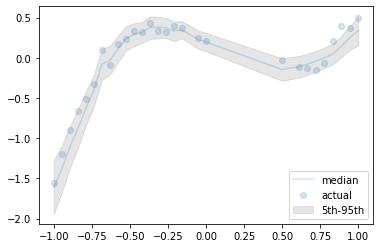

In [28]:
plt.scatter(df_slice['x1'], df_slice['y'], alpha=0.2, label='actual')
plt.plot(df_slice['x1'], p50.flatten(), alpha=0.2, label='median')
plt.fill_between(df_slice['x1'], p05.flatten(), p95.flatten(), color='gray', alpha=0.2, label='5th-95th')
plt.legend()
plt.show()

We can see the 5th and 95th percentile prediction bounds capture the variation of most points around the median estimate, and can be used to approximate the uncertainty in our model.